* Cory Clayton (acc2ds@virginia.edu)
- DS5001
- 6 May 2021


# Clustering the Animated Movies

## Set up

In [1]:
import pandas as pd
import numpy as np
import re 
from numpy.linalg import norm
from scipy.spatial.distance import pdist, squareform

In [2]:
data_in = 'data_in/'
data_out = 'data_out/'
data_prefix = 'movie'

## load data

In [3]:
animated_LIB=pd.read_csv(f'{data_in}{data_prefix}-LIB.csv')

In [4]:
animated_list=animated_LIB.query("studio in ['Pixar','Walt Disney Animation Studios']").movie_id.to_list()

In [5]:
animated_LIB=animated_LIB.query("studio in ['Pixar','Walt Disney Animation Studios']")
animated_LIB=animated_LIB.set_index("movie_id")

In [6]:
TOKENS=pd.read_csv(f'{data_in}{data_prefix}-TOKENS.csv')

In [7]:
TOKENS=TOKENS.query("movie_id in @animated_list")

In [8]:
VOCAB=pd.read_csv(f'{data_in}{data_prefix}-VOCAB.csv')

In [9]:
OHCO=['movie_id','Action_number','Dialogue_num','sent_num']

In [10]:
MOVIE=OHCO[:1]

In [11]:
ACTION=OHCO[:2]

In [12]:
DIALOGUE=OHCO[:3]

In [13]:
SENT=OHCO[:4]

## get tfidf for only animated movies

In [14]:
def get_tfidf(TOKEN,VOCAB,bag, tf_method='sum', item_type='term_str'):
    
    # Create bag of items (terms or stems)
    BOW = TOKEN.groupby(bag+[item_type])[item_type].count()\
        .to_frame().rename(columns={item_type:'n'})

    # Add binary count column
    BOW['c'] = BOW.n.astype('bool').astype('int')

    # Compute TF
    D = BOW.groupby(bag).n
    if tf_method == 'sum':
        BOW['tf'] = D.apply(lambda x: x / x.sum())
    elif tf_method == 'max':
        BOW['tf'] = D.apply(lambda x: .4 + .6 * (x / x.max())) # See Manning, et al. for choice of α
    elif tf_method == 'bool':
        BOW['tf'] = D.apply(lambda x: x.astype('bool') / x.astype('bool').sum())
    elif tf_method == 'raw':
        BOW['tf'] = BOW['n']
    elif tf_method == 'bool_raw':
        BOW['tf'] = BOW['c']
        
    # Compute DF
    VOCAB['df'] = BOW.groupby('term_str').n.count()
    N_docs = len(D.groups)
    VOCAB['idf'] = np.log2(N_docs/VOCAB.df)
    VOCAB['dfidf'] = VOCAB.df * VOCAB.idf
    
    # Compute TFIDF (local term significance)
    BOW['tfidf'] = BOW.apply(lambda x: x.tf * VOCAB.loc[x.name[-1]].idf, 1) #BOW.tf * VOCAB.idf
    
    # Compute aggregate TFIDF (global term significance)
    VOCAB['tfidf_sum'] = BOW.groupby('term_str').tfidf.sum()
        
    return BOW,VOCAB

In [15]:
VOCAB_subset=VOCAB[['term_str','n','num','stop','pos_max','p','s','i','h','wlen']]

## compute TFIDF table

In [16]:
TFIDF,updated_VOCAB=get_tfidf(TOKENS.set_index(OHCO),VOCAB_subset.set_index("term_str"),ACTION, tf_method='max', item_type='term_str')

In [17]:
TFIDF

n  c      tf     tfidf
movie_id Action_number term_str                         
m12      0.0           21st       1  1  0.4375  4.951368
                       a         11  1  0.8125  1.284571
                       again      1  1  0.4375  2.125367
                       all        3  1  0.5125  1.488190
                       although   1  1  0.4375  4.257947
...                              .. ..     ...       ...
m24      279.0         what       1  1  0.5000  1.080033
                       whered     1  1  0.5000  4.158706
                       yeah       1  1  0.5000  1.761498
                       yes        1  1  0.5000  2.034743
                       you        2  1  0.6000  0.694525

[70509 rows x 4 columns]

In [18]:
TFIDF=TFIDF.tfidf.unstack(fill_value=0)

In [19]:
VOCAB_SHORT=updated_VOCAB.sort_values("dfidf",ascending=False).head(4000).index.to_list()

### get TFIDF table by movie

In [20]:
TFIDF_movie = TFIDF.groupby(MOVIE).sum()

In [21]:
animated_LIB['tfidf_sum'] = TFIDF_movie.sum(1).sort_index()
animated_LIB['tfidf_mean'] = TFIDF_movie.mean(1).sort_index()

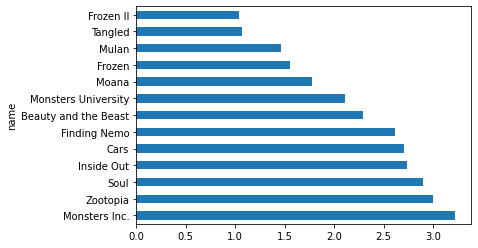

In [22]:
animated_LIB.sort_values('tfidf_sum', ascending=False).reset_index().set_index('name').tfidf_mean.plot.barh()

## Compute Pairs Table

In [23]:
PAIRS = pd.DataFrame(index=pd.MultiIndex.from_product([animated_LIB.index.tolist(), animated_LIB.index.tolist()])).reset_index()
PAIRS = PAIRS[PAIRS.level_0 < PAIRS.level_1].set_index(['level_0','level_1'])
PAIRS.index.names = ['doc_a', 'doc_b']

In [24]:
TFIDF_movie_short = TFIDF_movie[VOCAB_SHORT]
df=TFIDF_movie_short

In [25]:
L0 = df.astype('bool').astype('int') # Boolean
L1 = df.apply(lambda x: x / x.sum(), 1)
L2 = df.apply(lambda x: x / norm(x), 1)

In [26]:
PAIRS['cityblock'] = pdist(df, 'cityblock')
PAIRS['euclidean'] = pdist(df, 'euclidean')
PAIRS['cosine'] = pdist(df, 'cosine')
PAIRS['jaccard'] = pdist(L0, 'jaccard')
PAIRS['dice'] = pdist(L0, 'dice')
PAIRS['js'] = pdist(L1, 'jensenshannon')                               
PAIRS['euclidean2'] = pdist(L2, 'euclidean')

In [27]:
PAIRS.sort_values('cosine', ascending=False).style.background_gradient(cmap='GnBu', high=.5)

In [28]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [29]:
LABELS = animated_LIB.apply(lambda x: "{}: {} ({})".format(x.studio, x['name'], x.year), axis=1).values

## Dendrograms

In [32]:
def hca(sims, linkage_method='ward', color_thresh=.3, figsize=(10, 10)):
    tree = sch.linkage(sims, method=linkage_method)
    labels = LABELS
    plt.figure()
    fig, axes = plt.subplots(figsize=figsize)
    dendrogram = sch.dendrogram(tree, 
                                labels=list(labels), 
                                orientation="left", 
                                count_sort=True,
                                distance_sort=True,
                                above_threshold_color='.75',
                                color_threshold=color_thresh
                               )
    plt.tick_params(axis='both', which='major', labelsize=14)

<Figure size 432x288 with 0 Axes>

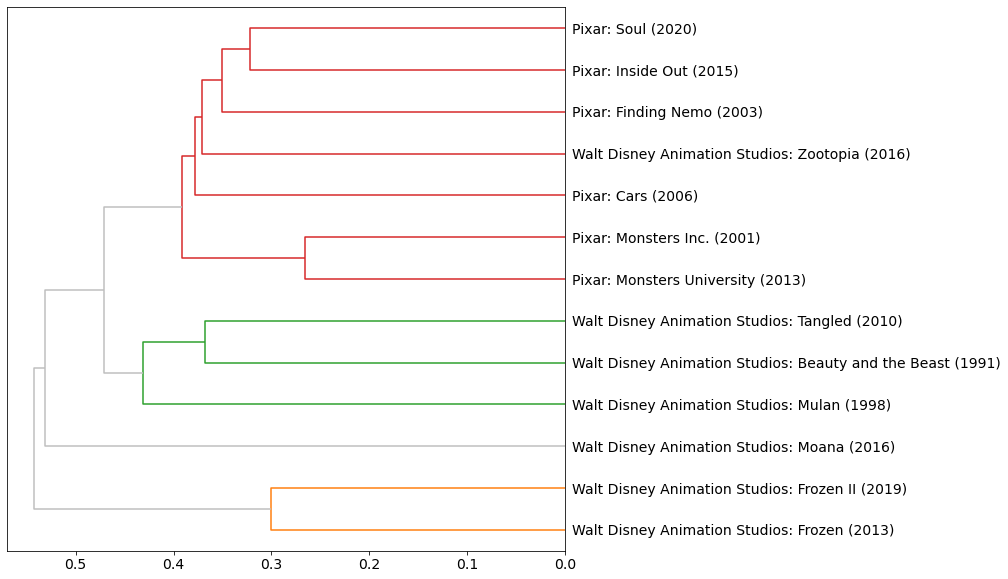

In [35]:
hca(PAIRS.cosine, color_thresh=0.45)

<Figure size 432x288 with 0 Axes>

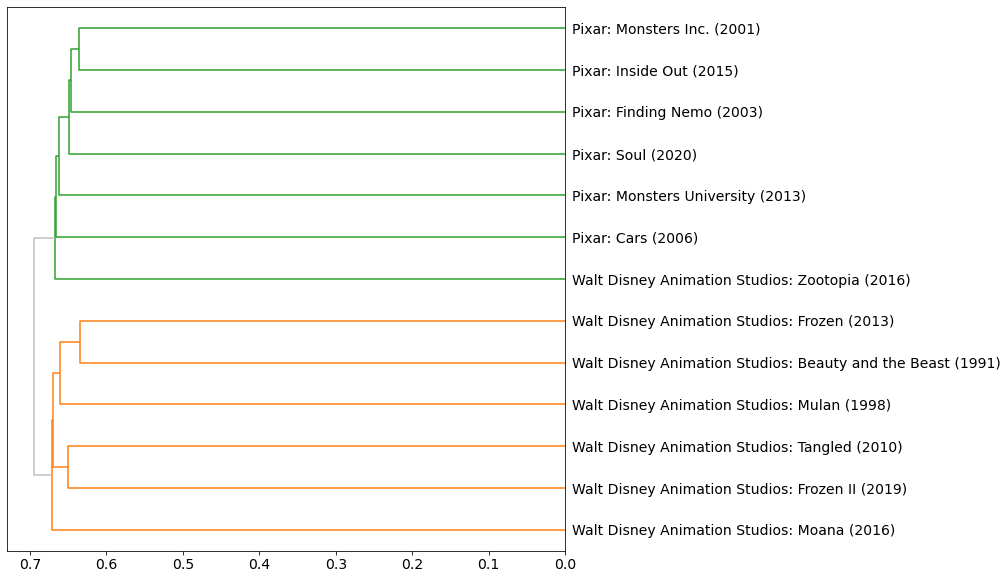

In [38]:
hca(PAIRS.jaccard, linkage_method='weighted', color_thresh=.69)

Pixar movies in one cluster + Zootopia, Princess movies in another cluster

<Figure size 432x288 with 0 Axes>

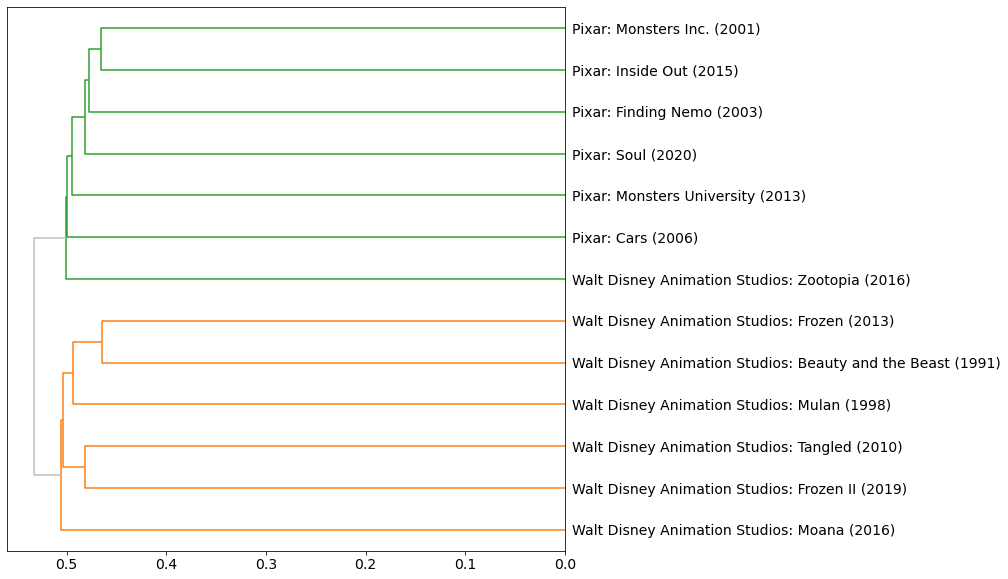

In [39]:
hca(PAIRS.dice, linkage_method='weighted', color_thresh=.53)